In [1]:
import pandas as pd 
import numpy as np
import lightgbm as lgbm
import sklearn as sk
import xgboost as xgb
from sklearn import model_selection
from sklearn import ensemble
from sklearn import preprocessing as sk_prep
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt


In [2]:
#load data from our local data folder
base_path = "./data/"
file = "churn_demo.csv"

#drop features that will not be useful, they are either identifiers of the customer or 
#personal information without any relation with their churn likelihood
df_base = pd.read_csv(base_path+file).drop(columns=['RowNumber', 'Surname', 'CustomerId'], axis = 1)

df_base.head(10)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [3]:
#how much data do we have?
print(df_base.shape)


(10000, 11)


In [4]:
#create metadata 
label = 'Exited'
df_columns = list(df_base.columns)
df_columns.remove(label)
print(df_columns)


['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [5]:
#encoders 
l_binarizer = sk_prep.LabelBinarizer()
str_encoder = sk_prep.OrdinalEncoder()

#binarize label
y_encoded = l_binarizer.fit_transform(y=df_base[label])

#encode strings
X_encoded = pd.DataFrame(str_encoder.fit_transform(X=df_base.drop(columns = [label], axis = 1)),
                            columns = df_columns)

X_encoded.head(10)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0
1,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0
2,111.0,0.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0
3,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0
4,459.0,2.0,0.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0
5,254.0,2.0,1.0,26.0,8.0,2674.0,1.0,1.0,0.0,7531.0
6,431.0,0.0,1.0,32.0,7.0,0.0,1.0,1.0,1.0,513.0
7,8.0,1.0,0.0,11.0,4.0,2781.0,3.0,1.0,0.0,5978.0
8,110.0,0.0,1.0,26.0,4.0,4962.0,1.0,0.0,1.0,3718.0
9,293.0,0.0,1.0,9.0,2.0,4450.0,0.0,1.0,1.0,3550.0


In [6]:
#split data in 70-30 ratios
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_encoded, y_encoded, test_size = 0.3)

print(X_train.shape, X_test.shape)


(7000, 10) (3000, 10)


In [7]:
#fit a random forest with 100 trees of maximum 8 levels
rf = ensemble.RandomForestClassifier(n_estimators = 100, 
        max_depth=8, criterion="entropy", n_jobs=-1)
rf.fit(X = X_train, y = y_train.ravel())


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [8]:
#function to plot the ROC curve
def get_roc_curve(X_train, y_train, X_test, y_test, model): 
    probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % auc)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--', color = "red")
    # plot the precision-recall curve for the model
    plt.plot(fpr, tpr, marker='.', color = "blue")
    # show the plot
    plt.show()


In [9]:
from sklearn import metrics

#predict using our test set and print different error measures
preds_proba_rf = rf.predict_proba(X=X_test)
preds_rf = rf.predict(X=X_test)

print("Accuracy: ", round(metrics.accuracy_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Precision: ", round(metrics.precision_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Recall: ", round(metrics.recall_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("F1: ", round(metrics.f1_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Confusion matrix: \n", confusion_matrix(y_test, preds_rf))


Accuracy:  0.86
Precision:  0.4
Recall:  0.85
F1:  0.55
Confusion matrix: 
 [[2330   44]
 [ 373  253]]


AUC: 0.865


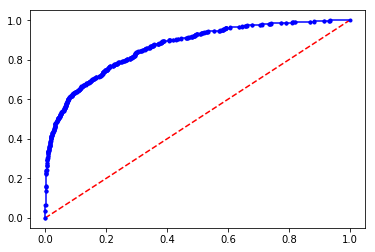

In [10]:
#get the roc curve to check if we are better than a random classifier
get_roc_curve(X_train, y_train,X_test, y_test, rf)


In [11]:
#tune our random forest
param_grid = {
    "max_depth": list(range(20, 300, 10)),
    "criterion":  ["gini", "entropy"],
    "max_features":  ["auto", "sqrt"],
    "min_samples_leaf": list(range(1, 5, 1)),
    "min_samples_split": list(range(2, 20, 2)),
    "n_estimators": [int(elems) for elems in list(np.logspace(np.log(100), np.log(800), base = np.exp(1), num = 30))]
}

#use 4 cores for each classifier and 2 models in parallel
rf = ensemble.RandomForestClassifier(n_jobs = 4)
n_iters = 20

random_search = model_selection.RandomizedSearchCV(estimator = rf, 
                                                   param_distributions = param_grid, 
                                                   n_iter = n_iters, scoring = 'f1', cv = 5, 
                                                   verbose = 1, n_jobs = 2)


In [12]:
#search in the random space
random_search.fit(X=X_train, y=y_train.ravel())


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [13]:
#get best model
best_rf = random_search.best_estimator_ 

#show best parameters
best_params_rf = random_search.best_params_
best_params_rf


{'n_estimators': 363,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 200,
 'criterion': 'gini'}

In [14]:
#predict using our test set and print different error measures
from sklearn import metrics

preds_proba_rf = best_rf.predict_proba(X=X_test)
preds_rf = best_rf.predict(X=X_test)

print("Accuracy: ", round(metrics.accuracy_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Precision: ", round(metrics.precision_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Recall: ", round(metrics.recall_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("F1: ", round(metrics.f1_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Confusion matrix: \n", confusion_matrix(y_test, preds_rf))


Accuracy:  0.86
Precision:  0.46
Recall:  0.81
F1:  0.59
Confusion matrix: 
 [[2307   67]
 [ 338  288]]


AUC: 0.860


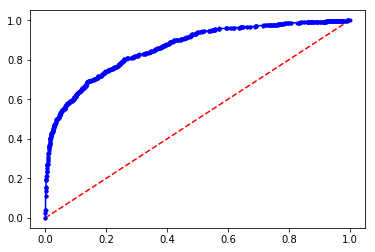

In [15]:
#get the roc curve to check if we are better than a random classifier
get_roc_curve(X_train, y_train,X_test, y_test, best_rf)

In [16]:
#load our imbalanced label library
from imblearn.over_sampling import ADASYN, SMOTE, SVMSMOTE

#OVERSAMPLING
sampler_smote = SMOTE(n_jobs = -1)
sampler_svm =  SVMSMOTE(n_jobs = -1)
sampler_adasyn = ADASYN(n_jobs = -1)

X_smote, y_smote = sampler_smote.fit_resample(X = X_train, y=y_train.ravel())
X_svm, y_svm = sampler_svm.fit_resample(X = X_train, y=y_train.ravel())
X_adasyn, y_adasyn = sampler_adasyn.fit_resample(X = X_train, y=y_train.ravel())

print(X_smote.shape, X_svm.shape, X_adasyn.shape)


Using TensorFlow backend.
(11178, 10) (11178, 10) (11248, 10)


In [17]:
#baseline
rf = ensemble.RandomForestClassifier(n_estimators = 100, max_depth=8, criterion="entropy", n_jobs=-1)
rf.fit(X = X_train, y = y_train.ravel())

#FROM NOW ON, USE THE TUNED VERSION ALTHOUGH WE SHOULD RE-TUNE
#weight classes using the model itself
rf_balanced = ensemble.RandomForestClassifier(n_jobs=-1,
                                              class_weight = "balanced_subsample", ##VERY IMPORTANT
                                              **best_params_rf)
rf_balanced.fit(X = X_train, y=y_train.ravel())

#weight classes + smote
rf_balanced_smote = ensemble.RandomForestClassifier(n_jobs=-1,
                                                    class_weight = "balanced_subsample", ##VERY IMPORTANT
                                                    **best_params_rf) 
rf_balanced_smote.fit(X = X_smote, y=y_smote.ravel())

#default SMOTE
rf_smote = ensemble.RandomForestClassifier(n_jobs=-1,
                                            **best_params_rf)
rf_smote.fit(X = X_smote, y = y_smote.ravel())

#default SVM SMOTE
rf_svm = ensemble.RandomForestClassifier(n_jobs=-1,
                            **best_params_rf)
rf_svm.fit(X = X_svm, y = y_svm.ravel())

#default ADASYN
rf_adasyn = ensemble.RandomForestClassifier(n_jobs=-1,
                            **best_params_rf)
rf_adasyn.fit(X = X_adasyn, y = y_adasyn.ravel())



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=200, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=363,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [18]:
from sklearn import metrics

##VERY IMPORTANT: ALL MODELS HAVE BEEN TRAINED WITH DIFFERENT DATASETS BUT ALL ARE TESTED AGAINST THE SAME TEST
preds_rf_smote = rf_smote.predict(X=X_test)
preds_rf_svm = rf_svm.predict(X=X_test)
preds_rf_adasyn = rf_adasyn.predict(X=X_test)
preds_rf = rf.predict(X=X_test)
preds_rf_balanced = rf_balanced.predict(X=X_test)
preds_rf_balanced_smote = rf_balanced_smote.predict(X=X_test)


In [19]:
#PRINT RESULTS
print("Accuracy BASELINE:", round(metrics.accuracy_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Precision BASELINE:", round(metrics.precision_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Recall BASELINE:", round(metrics.recall_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("F1 BASELINE:", round(metrics.f1_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))

print("Accuracy BALANCED:", round(metrics.accuracy_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))
print("Precision BALANCED:", round(metrics.precision_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))
print("Recall BALANCED:", round(metrics.recall_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))
print("F1 BALANCED:", round(metrics.f1_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))

print("Accuracy SMOTE:", round(metrics.accuracy_score(y_true = preds_rf_smote, y_pred = y_test.ravel()), 2))
print("Precision SMOTE:", round(metrics.precision_score(y_true = preds_rf_smote, y_pred = y_test.ravel()), 2))
print("Recall SMOTE:", round(metrics.recall_score(y_true = preds_rf_smote, y_pred = y_test.ravel()), 2))
print("F1 SMOTE:", round(metrics.f1_score(y_true = preds_rf_smote, y_pred = y_test.ravel()), 2))

print("Accuracy SMOTE SVM:", round(metrics.accuracy_score(y_true = preds_rf_svm, y_pred = y_test.ravel()), 2))
print("Precision SMOTE SVM:", round(metrics.precision_score(y_true = preds_rf_svm, y_pred = y_test.ravel()), 2))
print("Recall SMOTE SVM:", round(metrics.recall_score(y_true = preds_rf_svm, y_pred = y_test.ravel()), 2))
print("F1 SMOTE SVM:", round(metrics.f1_score(y_true = preds_rf_svm, y_pred = y_test.ravel()), 2))

print("Accuracy ADASYN:", round(metrics.accuracy_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel()), 2))
print("Precision ADASYN:", round(metrics.precision_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel()), 2))
print("Recall ADASYN:", round(metrics.recall_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel()), 2))
print("F1 ADASYN:", round(metrics.f1_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel()), 2))


Accuracy BASELINE: 0.86
Precision BASELINE: 0.4
Recall BASELINE: 0.85
F1 BASELINE: 0.55
Accuracy BALANCED: 0.86
Precision BALANCED: 0.48
Recall BALANCED: 0.78
F1 BALANCED: 0.6
Accuracy SMOTE: 0.86
Precision SMOTE: 0.49
Recall SMOTE: 0.75
F1 SMOTE: 0.59
Accuracy SMOTE SVM: 0.86
Precision SMOTE SVM: 0.48
Recall SMOTE SVM: 0.77
F1 SMOTE SVM: 0.59
Accuracy ADASYN: 0.86
Precision ADASYN: 0.49
Recall ADASYN: 0.74
F1 ADASYN: 0.59


In [20]:
#create objects to plot
precision_baseline = metrics.precision_score(y_true = preds_rf, y_pred = y_test.ravel())
precision_smote = metrics.precision_score(y_true = preds_rf_smote, y_pred = y_test.ravel())
precision_svm = metrics.precision_score(y_true = preds_rf_svm, y_pred = y_test.ravel())
precision_adasyn = metrics.precision_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel())
precision_balanced = metrics.precision_score(y_true = preds_rf_balanced, y_pred = y_test.ravel())
precision_balanced_smote = metrics.precision_score(y_true = preds_rf_balanced_smote, y_pred = y_test.ravel())

f1_baseline = metrics.f1_score(y_true = preds_rf, y_pred = y_test.ravel())
f1_smote = metrics.f1_score(y_true = preds_rf_smote, y_pred = y_test.ravel())
f1_svm = metrics.f1_score(y_true = preds_rf_svm, y_pred = y_test.ravel())
f1_adasyn = metrics.f1_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel())
f1_balanced = metrics.f1_score(y_true = preds_rf_balanced, y_pred = y_test.ravel())
f1_balanced_smote = metrics.f1_score(y_true = preds_rf_balanced_smote, y_pred = y_test.ravel())

accuracy_baseline = metrics.accuracy_score(y_true = preds_rf, y_pred = y_test.ravel())
accuracy_smote = metrics.accuracy_score(y_true = preds_rf_smote, y_pred = y_test.ravel())
accuracy_svm = metrics.accuracy_score(y_true = preds_rf_svm, y_pred = y_test.ravel())
accuracy_adasyn = metrics.accuracy_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel())
accuracy_balanced = metrics.accuracy_score(y_true = preds_rf_balanced, y_pred = y_test.ravel())
accuracy_balanced_smote = metrics.accuracy_score(y_true = preds_rf_balanced_smote, y_pred = y_test.ravel())

recall_baseline = metrics.recall_score(y_true = preds_rf, y_pred = y_test.ravel())
recall_smote = metrics.recall_score(y_true = preds_rf_smote, y_pred = y_test.ravel())
recall_svm = metrics.recall_score(y_true = preds_rf_svm, y_pred = y_test.ravel())
recall_adasyn = metrics.recall_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel())
recall_balanced = metrics.recall_score(y_true = preds_rf_balanced, y_pred = y_test.ravel())
recall_balanced_smote = metrics.recall_score(y_true = preds_rf_balanced_smote, y_pred = y_test.ravel())

precision_scores = [precision_baseline, precision_balanced, precision_balanced_smote, precision_smote, precision_svm, precision_adasyn]
f1_scores = [f1_baseline, f1_balanced, f1_balanced_smote, f1_smote, f1_svm, f1_adasyn]
accuracy_scores = [accuracy_baseline, accuracy_balanced, accuracy_balanced_smote, accuracy_smote, accuracy_svm, accuracy_adasyn]
recall_scores = [recall_baseline, recall_balanced, recall_balanced_smote, recall_smote, recall_svm, recall_adasyn]
score_names = ["Baseline", "Balanced", "Balanced_SMOTE", "SMOTE", "SMOTE_SVM", "ADASYN"]

d_prec={'Scores':precision_scores, 'Version': score_names}
precision_scores_df = pd.DataFrame(d_prec)

d_f1={'Scores':f1_scores, 'Version': score_names}
f1_scores_df = pd.DataFrame(d_f1)

d_accuracy = {'Scores':accuracy_scores, 'Version': score_names}
accuracy_scores_df = pd.DataFrame(d_accuracy) 

d_recall = {'Scores':recall_scores, 'Version': score_names}
recall_scores_df = pd.DataFrame(d_recall) 
 

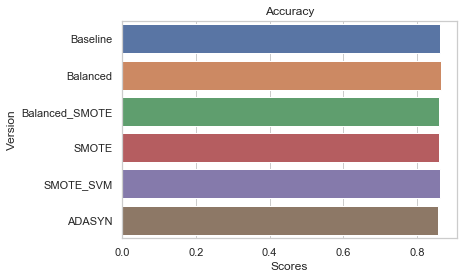

In [21]:
import seaborn as sns

#accuracy plot
sns.set(style="whitegrid")
ax = sns.barplot(x="Scores", y="Version", data = accuracy_scores_df).set_title("Accuracy")


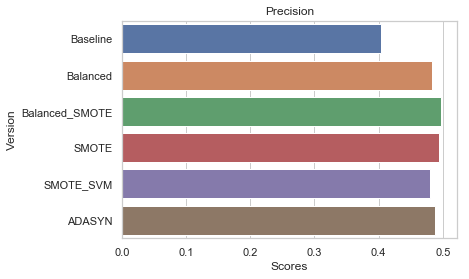

In [22]:
#precision plot
sns.set(style="whitegrid")
ax = sns.barplot(x="Scores", y="Version", data = precision_scores_df).set_title("Precision")


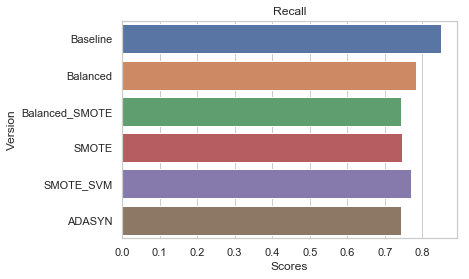

In [23]:
#recall plot
sns.set(style="whitegrid")
ax = sns.barplot(x="Scores", y="Version", data = recall_scores_df).set_title("Recall")


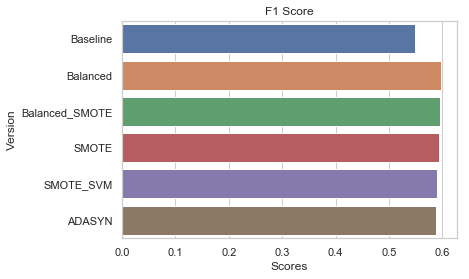

In [24]:
#f1 plot
sns.set(style="whitegrid")
ax = sns.barplot(x="Scores", y="Version", data = f1_scores_df).set_title("F1 Score")


Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Optimal number of features : 5


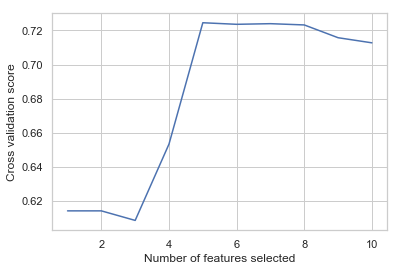

In [26]:
#RFE CV to train with less feats
from sklearn import feature_selection as fs 
from sklearn import linear_model as lin 
import matplotlib.pyplot as plt

lr = lin.LogisticRegression(class_weight = "balanced", 
                            solver = "lbfgs", max_iter = 100000)

rfe = fs.RFECV(estimator = lr, step = 1, n_jobs = -1, cv = 5, scoring='f1_weighted', verbose = 2)
rfe.fit(X=X_train, y=y_train.ravel())

print("Optimal number of features : %d" % rfe.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()


In [27]:
X_train_RFE = pd.DataFrame(rfe.transform(X_train), columns = X_train.columns[rfe.support_])
X_test_RFE = pd.DataFrame(rfe.transform(X_test), columns = X_test.columns[rfe.support_])

print(X_train.shape, X_train_RFE.shape)


(7000, 10) (7000, 5)


In [28]:
#RFE
rf_reduced = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators = 100, class_weight="balanced_subsample",
                                                max_depth = 8, criterion="entropy") #, **best_params_rf)
rf_reduced.fit(X = X_train_RFE, y=y_train.ravel())


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [29]:
preds_rf_reduced = rf_reduced.predict(X=X_test_RFE)


In [30]:
print("Accuracy REDUCED: ", round(metrics.accuracy_score(y_true = preds_rf_reduced, y_pred = y_test.ravel()), 2))
print("Precision REDUCED: ", round(metrics.precision_score(y_true = preds_rf_reduced, y_pred = y_test.ravel()), 2))
print("Recall REDUCED: ", round(metrics.recall_score(y_true = preds_rf_reduced, y_pred = y_test.ravel()), 2))
print("F1 REDUCED: ", round(metrics.f1_score(y_true = preds_rf_reduced, y_pred = y_test.ravel()), 2))


Accuracy REDUCED:  0.81
Precision REDUCED:  0.71
Recall REDUCED:  0.53
F1 REDUCED:  0.6


In [31]:
#create objects to plot
#OVERALL SCORE
accuracy_baseline = metrics.accuracy_score(y_true = preds_rf, y_pred = y_test.ravel())
accuracy_smote = metrics.accuracy_score(y_true = preds_rf_smote, y_pred = y_test.ravel())
accuracy_svm = metrics.accuracy_score(y_true = preds_rf_svm, y_pred = y_test.ravel())
accuracy_adasyn = metrics.accuracy_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel())
accuracy_balanced = metrics.accuracy_score(y_true = preds_rf_balanced, y_pred = y_test.ravel())
accuracy_reduced = metrics.accuracy_score(y_true = preds_rf_reduced, y_pred = y_test.ravel())

#PRECISION (CHURNED)
precision_baseline = metrics.precision_score(y_true = preds_rf, y_pred = y_test.ravel())
precision_smote = metrics.precision_score(y_true = preds_rf_smote, y_pred = y_test.ravel())
precision_svm = metrics.precision_score(y_true = preds_rf_svm, y_pred = y_test.ravel())
precision_adasyn = metrics.precision_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel())
precision_balanced = metrics.precision_score(y_true = preds_rf_balanced, y_pred = y_test.ravel())
precision_reduced = metrics.precision_score(y_true = preds_rf_reduced, y_pred = y_test.ravel())

#RECALL (NOT CHURNED)
recall_baseline = metrics.recall_score(y_true = preds_rf, y_pred = y_test.ravel())
recall_smote = metrics.recall_score(y_true = preds_rf_smote, y_pred = y_test.ravel())
recall_svm = metrics.recall_score(y_true = preds_rf_svm, y_pred = y_test.ravel())
recall_adasyn = metrics.recall_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel())
recall_balanced = metrics.recall_score(y_true = preds_rf_balanced, y_pred = y_test.ravel())
recall_reduced = metrics.recall_score(y_true = preds_rf_reduced, y_pred = y_test.ravel())

#F1 (HARMONIC MEAN BETWEEN CHURNED AND NOT CHURNED)
f1_baseline = metrics.f1_score(y_true = preds_rf, y_pred = y_test.ravel())
f1_smote = metrics.f1_score(y_true = preds_rf_smote, y_pred = y_test.ravel())
f1_svm = metrics.f1_score(y_true = preds_rf_svm, y_pred = y_test.ravel())
f1_adasyn = metrics.f1_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel())
f1_balanced = metrics.f1_score(y_true = preds_rf_balanced, y_pred = y_test.ravel())
f1_reduced = metrics.f1_score(y_true = preds_rf_reduced, y_pred = y_test.ravel())

precision_scores = [precision_baseline, precision_balanced, precision_reduced, precision_smote, precision_svm, precision_adasyn]
recall_scores = [recall_baseline, recall_balanced, recall_reduced, recall_smote, recall_svm, recall_adasyn]
f1_scores = [f1_baseline, f1_balanced, f1_reduced, f1_smote, f1_svm, f1_adasyn]
accuracy_scores = [accuracy_baseline, accuracy_balanced, accuracy_reduced, accuracy_smote, accuracy_svm, accuracy_adasyn]
score_names = ["Baseline", "Balanced", "Reduced", "SMOTE", "SMOTE_SVM", "ADASYN"]

d_prec={'Scores':precision_scores, 'Version': score_names}
precision_scores_df = pd.DataFrame(d_prec)

d_f1={'Scores':f1_scores, 'Version': score_names}
f1_scores_df = pd.DataFrame(d_f1)

d_accuracy = {'Scores':accuracy_scores, 'Version': score_names}
accuracy_scores_df = pd.DataFrame(d_accuracy) 

d_recall = {'Scores':recall_scores, 'Version': score_names}
recall_scores_df = pd.DataFrame(d_recall) 
 

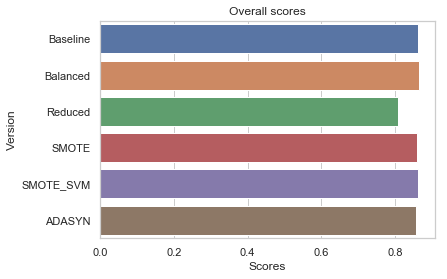

In [32]:
import seaborn as sns

#accuracy plot
sns.set(style="whitegrid")
ax = sns.barplot(x="Scores", y="Version", data = accuracy_scores_df).set_title("Overall scores")


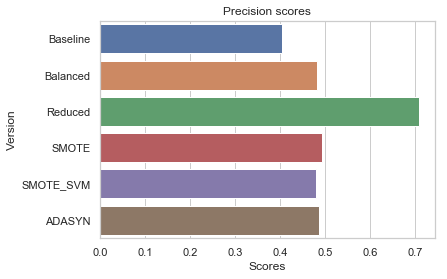

In [33]:
#precision plot
sns.set(style="whitegrid")
ax = sns.barplot(x="Scores", y="Version", data = precision_scores_df).set_title("Precision scores")


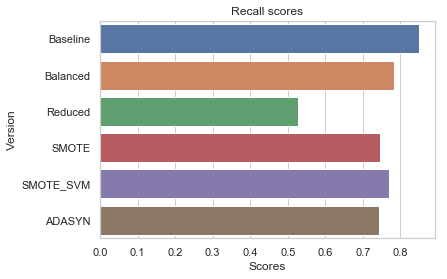

In [34]:
#recall plot
sns.set(style="whitegrid")
ax = sns.barplot(x="Scores", y="Version", data = recall_scores_df).set_title("Recall scores")


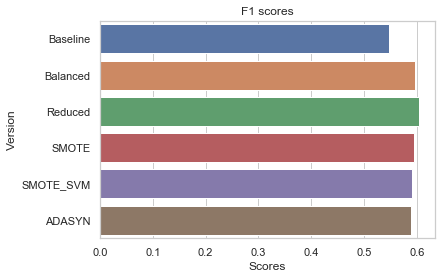

In [35]:
#f1 plot
sns.set(style="whitegrid")
ax = sns.barplot(x="Scores", y="Version", data = f1_scores_df).set_title("F1 scores")


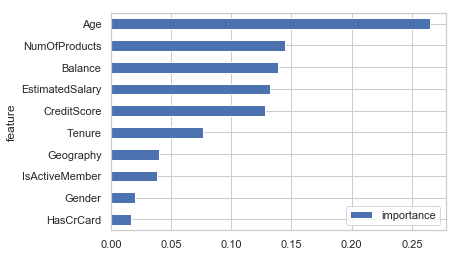

In [36]:
#feature importance for random forest model
importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance":rf_balanced.feature_importances_
}).sort_values("importance")
importance.plot.barh(x="feature", y="importance")
